## Synapses

Providing synaptic input to a neuron is equivalent to implementing $\sum_{k}{I_k(t)}$

$I_{syn}(t) = g_{syn}(t) (V(t)−E_{syn}) \tag{1}$


The time course of the synaptic conductance can be modelled as an exponential decay

$g_{syn}(t) = \sum_{s}^{S} \bar g_{max} e^{−(t−t_{s})/τ} \cdot Θ(t−t_{s}) \tag{2}$

Basically the conductance given a specific time $t$ point and all the incoming spike times $S$

This is further broken down into two parts

* The conductance at a given time point $t$ and a presynaptic spike time $t_s$ 
* The conductance at a given time point given by the sum for each spike time


- $\tau$ is the decay time constant
- $t_{s}$ denotes the arrival time of a presynaptic action potential - $s$ is each presynaptic *spike*.
- Θ(x) or $H(x)$ is the Heaviside step function

In [1]:
import numpy as np

In [2]:
def heaviside(x):
    
    return x >= 0

## Implementing the synaptic conductance $g_{syn}$

In [39]:
e = 2.71828   

def g_syn(t, spks, g_max=50, tau=5):
    """Single exponential conductance decay using equation 2 but limited to a single incoming spike (spk_t)
    g_max is in ns
    """
    
    total = 0.0
    for i in range(len(spks)):
        total += g_max * e**(-(t-spks[i])/tau) * float(heaviside(t-spks[i]))
    return total

t = 40
spks = [1.9, 22, 40]

g_syn(t, spks)

51.39071664792871

In [41]:
# Excitatory synapse
def I_AMPA(t, V_t, spks, g_max=50, tau=4, E=0):
    # ns is converted to mA with 1e-3
    return 1e-3 * g_syn(t, spks, g_max, tau) * (V_t-E)

# Inhibitory synaps
def I_GABA(t, V_t, spks, g_max=50, tau=8, E=-70):
    return 1e-3*g_syn(t, spks, g_max, tau) * (V_t-E)

In [46]:
t = 10    # time point
V_t = -64.2     # V_t at t

exc_spks = [1.9, 22, 40]    # spike times
inh_spks = np.random.randint(0, t, size=2)

i_ampa_result = I_AMPA(t, V_t, exc_spks)
i_gaba_result = I_GABA(t, V_t, inh_spks)
print(f"I_AMPA{t, V_t, exc_spks} = {i_ampa_result:>8.4f} mA")
print(f"I_GABA{t, V_t, inh_spks} = {i_gaba_result:>8.4f} mA")

I_AMPA(10, -64.2, [1.9, 22, 40]) =  -0.4237 mA
I_GABA(10, -64.2, array([2, 8])) =   0.3325 mA


In [48]:
# Neuronal parameters
V_rest = -65        # resting membrane potential
C_m = 1             # membrane capacitance (nF)
R_m = 100           # membrane resistance (MOhm)
I_e = 0             # external current (nA)
A = 10              # surface area of electrode (um^2)

# Simulation parameters
V_t = V_rest + 2
print(f"V_t at the start is {V_t:.2f} mV")
T = 100             # duration (ms)
dt = 0.1            # time step (ms)
spks = [1.9]        # a list of spike times (ms)

num_iter = round(T/dt)

for i in range(num_iter):
    t = i*dt      # time to evaluate at
    I_leak = (V_t - V_rest)/R_m     # leak current
    I_syn = I_GABA(t, V_t, inh_spks) + I_AMPA(t, V_t, exc_spks)  # synaptic input
    dV = (-I_leak - I_syn + I_e/A) * dt/C_m
    V_t = V_t + dV
    
print(f"V_t after {dt*num_iter} ms is {V_t:.2f} mV")

V_t at the start is -63.00 mV
V_t after 100.0 ms is -52.79 mV


## Ions

In [55]:
C = concentrations = {'K':    {'i':140,'o':  5},
                      'Na':   {'i': 15,'o':125},
                      'Cl':   {'i':  5,'o':135},
                      'HCO3': {'i': 10,'o': 25},
                      }

ion_names = list(concentrations.keys())
ion_names

['K', 'Na', 'Cl', 'HCO3']

### Reversal Potential

The reversal potetial is also known as the Nernst potential. This is the membrane potential at which there is no net (overall) flow of a particular ion from one side of the membrane to the other.

For a single ion species, the Nernst potential is used,

$ E = \frac{R \cdot T}{z \cdot F} \cdot \ln(\frac{[ion]_{out}}{[ion]_{in}})$

Where 
- $[ion]_{out}$ is the extracellular concentration of that ion (in moles per cubic meter, to match the other SI units, though the units strictly don't matter, as the ion concentration terms become a dimensionless ratio),
- $[ion]_{in}$ is the intracellular concentration of that ion (in moles per cubic meter),
- R is the ideal gas constant (joules per kelvin per mole),
- T is the temperature in kelvins,
- F is Faraday's constant (coulombs per mole).
- z is the charge of the ion species (e.g. +1 for $Na^+$ and -1 for $Cl^-$)

In [66]:

# Constants

R = 8.314   # Real gas constant (J K^-1 mol^-1)
F = 96485   # Faraday constant (C mol^-1)
T = 310.25  # Temperature (K)
RTF = R*T/F # All treated as constant for the simulations

z = valence = {'K': 1, 'Na': 1, 'Cl': -1,'HCO3': -1}

In [67]:
def nernst_ind(C_out, C_in, sign):
    """Calculate the Nernst potential (in mV) for given C out, C in, z

    >>> round(nernst_ind(135, 5, -1),2)
    -88.11
    """
    # note that log is the natural log (base e not base 10)
    return RTF/sign * np.log(C_out/C_in)*1000

def nernst(ion, conc=None):
    """Calculate the Nernst potential (in mV) for a given ion.
     The ion concentrations are retrieved from the conc dict.
     The ion valences are retrieved from the valence dict.

     >>> round(nernst('Cl', conc=dict(Cl=dict(i=5, o=135))),2)
     -88.11
    """
    if conc is None:
        # use global values
        conc=concentrations
    return nernst_ind(conc[ion]['o'], conc[ion]['i'], valence[ion])

### Resting membrane potential

To calculate the equilibrium potential for section of membrane that is permeable to *multiple* ion species, the Goldman-Hodgkin-Katz (GHK) equation is used.

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/e290b78cf2f968293d8dde2a4732c6d22c6d1226)

Where 
- $P$ is the relative permeability of that ion (or selectivity in meters per second)
- $M$ are monovalent cations (*positive* ions with a single charge)
- $A$ are monovalent anions (*negative* ions with a single charge)

In [68]:
#-----------------------------
# Parameters
#-----------------------------
# GABAA receptor
pcl = 0.8   # Cl permeability
phco3 = 0.2 # HCO3 permeability

# membrane permeability to ions (multiple values have been found in the lit)
pK = 1
pNa = 0.05
pCl = 0.45


In [69]:
def ghk(C_outs, C_ins, ps, zs):
    """Calculate the potential of given ions using the Goldman–Hodgkin–Katz (GHK)
    equation.
    >>> round(ghk([4,125,110], [150,15,10], [pK, pNa, pCl], [1,1,-1]),2)
    -69.73
    """
    dividend = 0
    divisor = 0
    for cin, cout, p, z  in zip(C_ins, C_outs, ps, zs):
        assert abs(z) == 1, "only monovalent ions supported"
        if z>0:
            dividend += p*cout
            divisor += p*cin
        else:
            dividend += p*cin
            divisor += p*cout
    return RTF*np.log(dividend/divisor)*1000


#### **1.1**
  Experiments have shown that $GABA_A$ can be excitatory ($V_m - E_{GABA} < 0$ ). 
  
  Given 
  $\begin{align}
  [Cl^-]_o &= 135 mM\\
  [HCO_3^-]_o &= 25 mM \\
  [HCO_3^-]_i &= 10 mM \\
  V_m &= -65 mV
  \end{align}$, what value for $[Cl^-]_i$ elicits a negative *driving force* $(V_m - E_{GABA})$? 

In [175]:
x = np.arange(0, 135)
z = valence = {'K': 1, 'Na': 1, 'Cl': -1,'HCO3': -1}
z = [z['Cl'], z['HCO3']]
Vm = -65
C_outs = [135, 25]
Em_list = []
driv_list = []             
check = False           # to check if a negative driving force has been achieved

for Cl_i in x:
    C_ins = [Cl_i,10]
    ps = [pcl, phco3]
    
    Em = ghk(C_outs, C_ins, ps, z)
    Em_list.append(Em)
    driv_list.append(Vm-Em)
    if Vm - Em < 0 and check == False:
        print(f'The value of [Cl-] that elicits a negative driving force of {Vm-Em} is >= {Cl_i}')
        check = True

The value of [Cl-] that elicits a negative driving force of -0.17561269038506566 is >= 10


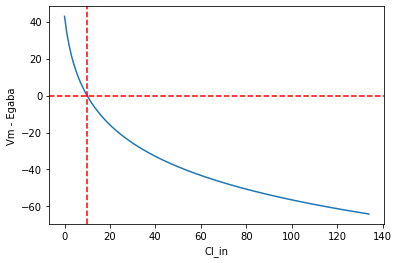

In [184]:
import matplotlib.pyplot as plt

y = np.arange(1, 12)
plt.plot(x, driv_list)
plt.xlabel('Cl_in')
plt.ylabel('Vm - Egaba')

plt.axvline(x=10, color='r', linestyle='--')
plt.axhline(y=-0.1, color='r', linestyle='--')

plt.show()